# 1. Imports

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from datetime import datetime
from copy import deepcopy
import pandas as pd
import xgboost
import plotly.express as px
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import ndcg_score, precision_score, recall_score, f1_score
pd.get_option("display.max_columns");

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Kindly change the link to data file 
sessions = pd.read_csv(r"/content/drive/MyDrive/AML-Airbnb/dataset/sessions.csv")
train_users = pd.read_csv(r'/content/drive/MyDrive/AML-Airbnb/dataset/train_users_2.csv')
test_users = pd.read_csv(r'/content/drive/MyDrive/AML-Airbnb/dataset/test_users.csv')

# 2. Dataset 

## Session Dataset 

In [ ]:
print(len(sessions))
sessions.head()

10567737


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [ ]:
for ele in sessions.columns:
    print(" {} contains {} null values".format(ele,  (sum(sessions[ele].isnull()) / len(sessions)) * 100)) 

 user_id contains 0.3264275028797556 null values
 action contains 0.7534820368826363 null values
 action_type contains 10.657002535169072 null values
 action_detail contains 10.657002535169072 null values
 device_type contains 0.0 null values
 secs_elapsed contains 1.2872292336571207 null values


## Users Dataset

In [ ]:
print(len(train_users))
train_users.head()

213451


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [ ]:
for ele in train_users.columns:
    if (sum(train_users[ele].isnull()) / len(train_users)) == 0:
        continue
    print(" {} contains {} null values".format(ele,  (sum(train_users[ele].isnull()) / len(train_users)) * 100)) 

 date_first_booking contains 58.34734904029496 null values
 age contains 41.222575673105304 null values
 first_affiliate_tracked contains 2.84140153946339 null values


## Data Processing

### Users

For Age column, we set missing age and all age not in range from 15 to 100 is median age

In [ ]:
MEDIAN_AGE = train_users['age'].median()  # taking median because data is skewed
# age
train_users['age'].fillna(MEDIAN_AGE,inplace=True) # Handle Null values and Outliers for Age
train_users.loc[train_users['age'] > 100,'age'] = MEDIAN_AGE
train_users.loc[train_users['age'] < 15,'age']= MEDIAN_AGE
train_users['age']=train_users['age'].astype('int32')  # Handle mismatched Dtypes

Next, we parse date columns and extract date features from them

In [ ]:
train_users['timestamp_first_active']=train_users['timestamp_first_active'].apply(lambda s:datetime(year=int(str(s)[0:4]), month=int(str(s)[4:6]), 
                                                                                day=int(str(s)[6:8])).strftime('%Y-%m-%d'))
                                                                                
train_users['timestamp_first_active']=train_users['timestamp_first_active'].astype('datetime64[ns]') #handle mismatched dtype

# Extract Date features from the date columns
train_users['TFA_year']=train_users['timestamp_first_active'].dt.year
train_users['TFA_month']=train_users['timestamp_first_active'].dt.month
train_users['TFA_day']=train_users['timestamp_first_active'].dt.day


train_users['date_account_created'] = train_users['date_account_created'].astype('datetime64[ns]') #handle mismatched dtype
train_users['DAC_year']=train_users['date_account_created'].dt.year
train_users['DAC_month']=train_users['date_account_created'].dt.month
train_users['DAC_day']=train_users['date_account_created'].dt.day


Same process with testing dataset

In [ ]:
# age
test_users['age'].fillna(MEDIAN_AGE,inplace=True) # Handle Null values and Outliers for Age
test_users.loc[test_users['age'] > 100,'age'] = MEDIAN_AGE
test_users.loc[test_users['age'] < 15,'age']= MEDIAN_AGE
test_users['age']=test_users['age'].astype('int32')  # Handle mismatched Dtypes


# Parse the timestamp_first_active attribute
test_users['timestamp_first_active'] = test_users['timestamp_first_active'].apply(lambda s:datetime(year=int(str(s)[0:4]),
                                                                  month=int(str(s)[4:6]),day=int(str(s)[6:8])).strftime('%Y-%m-%d'))
                                                                                
test_users['timestamp_first_active']=test_users['timestamp_first_active'].astype('datetime64[ns]')  #handle mismatched dtype

# Extract Date features from the date columns
test_users['TFA_year']=test_users['timestamp_first_active'].dt.year
test_users['TFA_month']=test_users['timestamp_first_active'].dt.month
test_users['TFA_day']=test_users['timestamp_first_active'].dt.day

test_users['date_account_created'] = test_users['date_account_created'].astype('datetime64[ns]')
test_users['DAC_year']=test_users['date_account_created'].dt.year
test_users['DAC_month']=test_users['date_account_created'].dt.month
test_users['DAC_day']=test_users['date_account_created'].dt.day


In [ ]:
# drop unnecessary columns
train_users.drop(['date_account_created', 'timestamp_first_active', 'date_first_booking'],axis=1, inplace= True)
test_users.drop(['date_account_created', 'timestamp_first_active', 'date_first_booking'],axis=1, inplace= True)

In [ ]:
# fill missing values of 'first_affiliate_tracked' attribute with the mode of the column
train_users['first_affiliate_tracked'].fillna(value=train_users.first_affiliate_tracked.mode()[0],inplace = True)

test_users['first_affiliate_tracked'].fillna(value=train_users.first_affiliate_tracked.mode()[0],inplace = True)

### Sessions

For action type, we set missing value as 'other'<br>
For secs_elapsed, we set missing value as 0

In [ ]:
print("DF Length",len(sessions))
sessions.dropna(subset=['user_id','action'],inplace=True)
sessions.action_type=sessions.action_type.fillna('Other')
sessions.secs_elapsed=sessions.secs_elapsed.fillna(0)
sessions.head()

DF Length 10567737


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,Other,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,Other,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,Other,NaN,Windows Desktop,435.0


In [ ]:
sessions_copy = sessions.__deepcopy__()
sessions_copy.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,Other,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,Other,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,Other,NaN,Windows Desktop,435.0


In [ ]:
# aggregate the action, action type, detail values for each user_id

sessions_copy =  sessions.groupby("user_id", as_index= False).agg(lambda x:x.tolist())

sessions_copy['action_detail'].fillna(value = 'na',inplace = True)

def convert_to_string(action):
    action = [str(i) for i in action]
    action = [re.sub("nan","",i) for i in action]
    action = ",".join(action)
    return action

sessions_copy["action"] = sessions_copy["action"].apply(convert_to_string)
sessions_copy["action_type"] = sessions_copy["action_type"].apply(convert_to_string)
sessions_copy["action_detail"] = sessions_copy["action_detail"].apply(convert_to_string)


### Feature Engineering

Here we take group different actions based on how they influence the booking intent of a user. (Ex. NDF vs non-NDF)

In [ ]:
sessions_copy['apply_coupon'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('apply_coupon') != -1 else 0)
sessions_copy['cancellation_actions'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('cancellation_polic') != -1 else 0)
sessions_copy['phone_actions'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('phone') != -1 else 0)
sessions_copy['message_actions'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('message') != -1 else 0)
sessions_copy['profile_actions'] = sessions_copy["action_detail"].apply(lambda x:1 if x != 'user_profile' and x.find('profile') != -1 else 0 )
sessions_copy['listing_actions'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('list_your_space') or x.find('listing') != -1 else 0)
sessions_copy['notification_actions'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('notifications') != -1 else 0)
sessions_copy['social_connections'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('user_social_connections') != -1 else 0)
sessions_copy['at_checkpoint'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('at_checkpoint') != -1 else 0)
sessions_copy['change_actions'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('change') != -1 else 0)
sessions_copy['confirm_email'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('confirm_email') != -1 else 0)
sessions_copy['contact_host'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('contact_host') != -1 else 0)
sessions_copy['dashboard'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('dashboard') != -1 else 0)
sessions_copy['your_trips'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('your_trips') != -1 else 0)
sessions_copy['reservations'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('reservation') != -1 else 0)
sessions_copy['oauth_login'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('oauth_login') != -1 else 0)
sessions_copy['oauth_response'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('oauth_response') != -1 else 0)
sessions_copy['listing_reviews'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find('listing_reviews') != -1 else 0)
for ele in ['p1','p3','p4','p5']:
    sessions_copy[f'{ele}_indicator'] = sessions_copy["action_detail"].apply(lambda x: 1 if x.find(ele) != -1 else 0)


In [ ]:
sessions_copy = sessions_copy.drop([ 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed'],axis = 1)
sessions_copy.columns

Index(['user_id', 'apply_coupon', 'cancellation_actions', 'phone_actions',
       'message_actions', 'profile_actions', 'listing_actions',
       'notification_actions', 'social_connections', 'at_checkpoint',
       'change_actions', 'confirm_email', 'contact_host', 'dashboard',
       'your_trips', 'reservations', 'oauth_login', 'oauth_response',
       'listing_reviews', 'p1_indicator', 'p3_indicator', 'p4_indicator',
       'p5_indicator'],
      dtype='object')

In [ ]:
sessions_copy.head()

,user_id,apply_coupon,cancellation_actions,phone_actions,message_actions,profile_actions,listing_actions,notification_actions,social_connections,at_checkpoint,...,dashboard,your_trips,reservations,oauth_login,oauth_response,listing_reviews,p1_indicator,p3_indicator,p4_indicator,p5_indicator
0,00023iyk9l,0,0,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,1,0,1
1,0010k6l0om,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,001wyh0pz8,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0028jgx1x1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,002qnbzfs5,0,0,1,1,1,1,1,1,1,...,1,0,1,0,0,1,0,1,0,0


Here, we categorize actions based on the elapsed session time to include a information on the kind of activity that was performed on the session. 

In [ ]:
sessions['is_live_action'] = sessions.secs_elapsed.apply(lambda x : True if x < 60 else False)
sessions['is_typeB_action'] = sessions.secs_elapsed.apply(lambda x : True if x >= 60 and x <=600 else False)
sessions['is_typeC_action'] = sessions.secs_elapsed.apply(lambda x : True if x > 600 and x <=7200 else False)
sessions['is_typeD_action'] = sessions.secs_elapsed.apply(lambda x : True if x > 7200 and x <=86400 else False)
sessions['is_typeE_action'] = sessions.secs_elapsed.apply(lambda x : True if x > 86400 else False)
total_session_by_type = sessions.groupby("user_id", as_index = False).sum()
total_session_by_type.columns = ['user_id', 'secs_elapsed', 'total_quick_actions', 'total_careful_actions',
       'total_pause_actions', 'total_afk_actions', 'total_long_afk_actions']
total_session_by_type.head()

,user_id,secs_elapsed,total_quick_actions,total_careful_actions,total_pause_actions,total_afk_actions,total_long_afk_actions
0,00023iyk9l,738079.0,4,10,18,6,1
1,0010k6l0om,586543.0,13,14,21,13,2
2,001wyh0pz8,282965.0,2,18,61,9,0
3,0028jgx1x1,297010.0,5,11,4,11,0
4,002qnbzfs5,6463327.0,162,245,270,92,13


In [ ]:
merged_session_features = total_session_by_type.merge(sessions_copy, on= 'user_id', how= 'inner')

In [ ]:
# create general set of features such as:
# total number of actions
# number of unique actions
# statistics of the session time 
# number of devices that were used 

sessions_temp_1 = sessions.groupby(['user_id','action_type']).agg({'action':['count', 'nunique'],
                                                                   'secs_elapsed':['sum','max','mean'],
                                                                   'device_type' : ['nunique']}).reset_index()

# Rename the columns to reflect the meaning of the predictor variable 
sessions_temp_1.columns = ['user_id','action_type','count_actions','num_unique_actions',
                            'total_secs_elapsed','max_secs_elapsed','avg_secs_elapsed','num_devices_used']

# One hot encode action_type column
sessions_final = pd.get_dummies(sessions_temp_1,columns=['action_type']).groupby(['user_id']).sum().reset_index()
sessions_final.head()

,user_id,count_actions,num_unique_actions,total_secs_elapsed,max_secs_elapsed,avg_secs_elapsed,num_devices_used,action_type_-unknown-,action_type_Other,action_type_booking_request,action_type_booking_response,action_type_click,action_type_data,action_type_message_post,action_type_modify,action_type_partner_callback,action_type_submit,action_type_view
0,00023iyk9l,39,14,738079.0,613443.0,155417.543651,9,0,1,1,0,1,1,0,0,1,0,1
1,0010k6l0om,63,13,586543.0,303074.0,59247.083170,6,1,1,0,0,1,1,0,0,1,0,1
2,001wyh0pz8,90,11,282965.0,109373.0,30414.200000,6,1,1,0,0,1,1,0,0,0,1,1
3,0028jgx1x1,31,5,297010.0,140663.0,30284.222222,5,1,0,0,0,1,1,0,0,0,1,1
4,002qnbzfs5,782,32,6463327.0,2286069.0,252693.669272,12,1,1,1,0,1,1,1,0,0,1,1


In [ ]:
sessions_final = sessions_final.merge(merged_session_features, on = 'user_id', how = 'inner')
sessions_final.head()

,user_id,count_actions,num_unique_actions,total_secs_elapsed,max_secs_elapsed,avg_secs_elapsed,num_devices_used,action_type_-unknown-,action_type_Other,action_type_booking_request,...,dashboard,your_trips,reservations,oauth_login,oauth_response,listing_reviews,p1_indicator,p3_indicator,p4_indicator,p5_indicator
0,00023iyk9l,39,14,738079.0,613443.0,155417.543651,9,0,1,1,...,1,1,0,0,1,0,0,1,0,1
1,0010k6l0om,63,13,586543.0,303074.0,59247.083170,6,1,1,0,...,1,0,0,0,1,0,0,1,0,0
2,001wyh0pz8,90,11,282965.0,109373.0,30414.200000,6,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0028jgx1x1,31,5,297010.0,140663.0,30284.222222,5,1,0,0,...,0,0,0,0,0,1,0,1,0,0
4,002qnbzfs5,782,32,6463327.0,2286069.0,252693.669272,12,1,1,1,...,1,0,1,0,0,1,0,1,0,0


In [ ]:
# Training data shape 
final_train = train_users.merge(sessions_final,left_on=['id'],
                               right_on=['user_id'],how='inner').drop(['user_id'],axis=1).reset_index(drop=True)
final_train.shape

(73406, 64)

In [ ]:
# Testing data shape
final_test=test_users.merge(sessions_final,left_on=['id'],
                               right_on=['user_id'],how='left').drop(['user_id'],axis=1).reset_index(drop=True)
final_test.shape

(62096, 63)

In [ ]:
# Info for train data
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73406 entries, 0 to 73405
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            73406 non-null  object 
 1   gender                        73406 non-null  object 
 2   age                           73406 non-null  int32  
 3   signup_method                 73406 non-null  object 
 4   signup_flow                   73406 non-null  int64  
 5   language                      73406 non-null  object 
 6   affiliate_channel             73406 non-null  object 
 7   affiliate_provider            73406 non-null  object 
 8   first_affiliate_tracked       73406 non-null  object 
 9   signup_app                    73406 non-null  object 
 10  first_device_type             73406 non-null  object 
 11  first_browser                 73406 non-null  object 
 12  country_destination           73406 non-null  object 
 13  T

In [ ]:
# Info for test data
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            62096 non-null  object 
 1   gender                        62096 non-null  object 
 2   age                           62096 non-null  int32  
 3   signup_method                 62096 non-null  object 
 4   signup_flow                   62096 non-null  int64  
 5   language                      62096 non-null  object 
 6   affiliate_channel             62096 non-null  object 
 7   affiliate_provider            62096 non-null  object 
 8   first_affiliate_tracked       62096 non-null  object 
 9   signup_app                    62096 non-null  object 
 10  first_device_type             62096 non-null  object 
 11  first_browser                 62096 non-null  object 
 12  TFA_year                      62096 non-null  int64  
 13  T

In [ ]:
# fill up missing values 
final_test.iloc[:,18:]=final_test.iloc[:,18:].fillna(-1)  

In [ ]:
# One hot encode other categorical variables
cat_cols = ['gender', 
            'signup_method',
            'first_device_type', 
            'first_browser', 
            'language', 
            'affiliate_channel', 
            'affiliate_provider', 
            'first_affiliate_tracked', 
            'signup_app']

OHE_COLS = []

for col in cat_cols:
    train_one_hot_cols = pd.get_dummies(final_train[col],prefix = col)
    final_train.drop([col], axis = 1, inplace = True)

    test_one_hot_cols = pd.get_dummies(final_test[col],prefix = col)
    final_test.drop([col], axis = 1, inplace = True)
        

    OHE_COLS.append(train_one_hot_cols.columns)
    
    # Get missing columns in the training test
    missing_cols = set( train_one_hot_cols.columns ) - set( test_one_hot_cols.columns )
    for column in missing_cols:
        
        test_one_hot_cols[column] = 0
    
    test_one_hot_cols = test_one_hot_cols[train_one_hot_cols.columns]
    
    final_train = pd.concat((final_train, train_one_hot_cols), axis=1)    
 
        
    final_test = pd.concat((final_test, test_one_hot_cols), axis=1)

        

In [ ]:
# Label encode the target variable i.e, country_destination
labels = final_train.country_destination
le = LabelEncoder()
y_train = le.fit_transform(labels) 
test_id = final_test.id
X_test = final_test.drop(['id'], axis='columns')

X_train = final_train.drop(['id','country_destination'], axis=1)

final_train.shape,X_train.shape,y_train.shape

((73406, 166), (73406, 164), (73406,))

In [ ]:
# final_train[['country_destination']]
country_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
country_mapping

{'AU': 0,
 'CA': 1,
 'DE': 2,
 'ES': 3,
 'FR': 4,
 'GB': 5,
 'IT': 6,
 'NDF': 7,
 'NL': 8,
 'PT': 9,
 'US': 10,
 'other': 11}

# 3. Model Building

In [ ]:
def cross_validation_with_ndcg(model, X, y, scorer, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=100)
    # initialize score array
    scores = []
    for train_index, holdout_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[holdout_index]
        y_train, y_test = y[train_index], y[holdout_index]
        model.fit(X_train, y_train)
        predict = model.predict_proba(X_test)
        y_test = pd.get_dummies(y_test).to_numpy()
        score = scorer(y_test, predict)
        scores.append(round(score, 6))
        print(f'{len(scores)} / {cv} DONE!', end='\r')
    return scores


## 3.1 Logistic Regression - Multinomial

In [ ]:
from sklearn.linear_model import LogisticRegression
logr_mlt = LogisticRegression(n_jobs=-1,multi_class='multinomial',solver='newton-cg')
logr_mlt.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', n_jobs=-1, solver='newton-cg')

In [ ]:
cross_validation_with_ndcg(logr_mlt, X_train,y_train, ndcg_score, cv=5)

[0.831432, 0.833737, 0.832887, 0.831906, 0.831543]

## 3.2 Bernoulli Naive Bayes

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb = bnb.fit(X_train, y_train)

parameters = {'alpha': (list(range(500,1000))),
             'fit_prior':['True','False']}

bnb = GridSearchCV(bnb, parameters, cv=5)
bnb.fit(X_train, y_train)

print(bnb.best_params_)


model_2 = BernoulliNB(alpha=779, fit_prior=True)
model_2.fit(X_train, y_train)

{'alpha': 779, 'fit_prior': 'True'}


BernoulliNB(alpha=779)

NDCG Score in cross validation

In [ ]:
cross_validation_with_ndcg(model_2, X_train,y_train, ndcg_score, cv=5)

[0.851368, 0.851923, 0.852095, 0.851625, 0.849195]

## 3.3 Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
change = ['TFA_year', 'TFA_month', 'TFA_day', 'DAC_year', 'DAC_month', 'DAC_day']
for var in change:
  X_train[change] = X_train[change].astype('int32')

best_dt = DecisionTreeClassifier(max_depth=29, max_features=22, max_leaf_nodes=12,random_state=100)

NDCG Score in cross validation

In [ ]:
cross_validation_with_ndcg(best_dt, X_train,y_train, ndcg_score, cv=5)

[0.849418, 0.855212, 0.854746, 0.851849, 0.847228]

In [ ]:
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=29, max_features=22, max_leaf_nodes=12,
                       random_state=100)

## 3.4  Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
best_rf = RandomForestClassifier(max_depth=5, max_features=14, max_leaf_nodes=16, n_estimators=700, random_state=100)

NDCG score in cross validation

In [ ]:
cross_validation_with_ndcg(best_rf, X_train,y_train, ndcg_score, cv=5)

[0.853067, 0.854425, 0.854665, 0.854523, 0.85271]

In [ ]:
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=14, max_leaf_nodes=16,
                       n_estimators=700, random_state=100)

## 3.5 XGBoost Classifer

In [ ]:
model_1 = XGBClassifier(max_depth=5,learning_rate=0.1, n_estimators=200,verbosity=1,
                              objective='multi:softprob',n_jobs=-1)

NDCG Score in cross validation

In [ ]:
cross_validation_with_ndcg(model_1, X_train,y_train, ndcg_score, cv=5)

[0.864169, 0.865258, 0.866509, 0.864964, 0.863089]

In [ ]:
xg_model = XGBClassifier(max_depth=5,learning_rate=0.1, n_estimators=200,verbosity=0,objective='multi:softprob',n_jobs=-1)
xg_model.fit(X_train, y_train)


XGBClassifier(max_depth=5, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', verbosity=0)

Make Submission (for kaggle)

In [ ]:
def make_submisson(model_name, predict):
  ids = []
  cts = []
  for i in range(len(test_id)):
      idx = test_id[i]
      ids += [idx] * 5
      cts += le.inverse_transform(np.argsort(predict[i])[::-1])[:5].tolist()
  sub_df = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
  sub_df.to_csv(f'{model_name}_submission.csv',index=False)  

# Feature Importance

In [ ]:
'''
weight: XGBoost contains several decision trees. In each of them, you'll use some set of features to classify the bootstrap sample.
This type basically counts how many times your feature is used in your trees for splitting purposes.
'''

feature_importance = xg_model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).reset_index()
data.columns = ['feature_name','score']
fig = px.bar(data[:20], x='feature_name', y='score',
            color = data['score'][:20], color_continuous_scale=px.colors.sequential.Pinkyl)

layout = dict(
    title_text = "<b> Top 10 features for XGBoost model by weight</b>",
    xaxis_title=" Feature Name",
    yaxis_title="Importance",
    title_x = 0.5)

fig.update_layout(layout,font_family="Arial", font_size = 12, title_x = 0.5, 
                     yaxis={'categoryorder':'total ascending'}, template = 'simple_white')
fig.show()

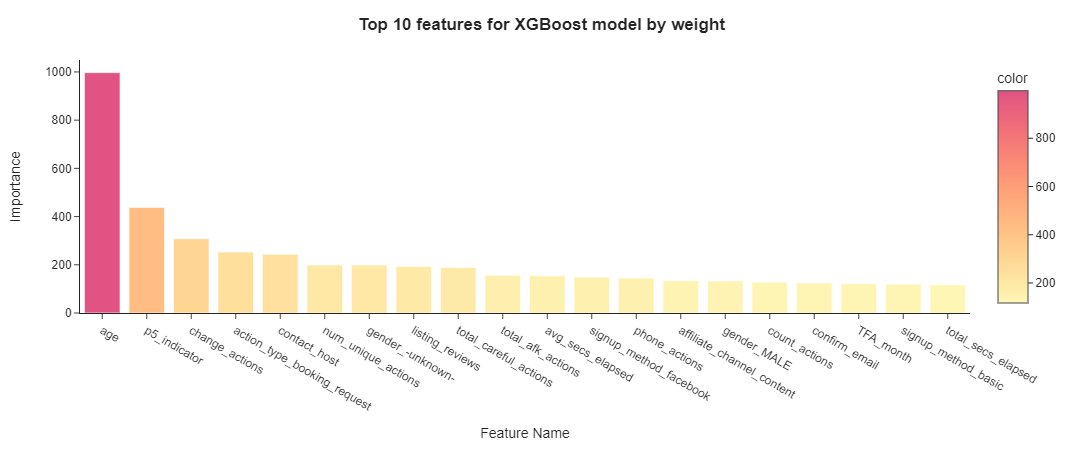

In [ ]:
'''
Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. 
A higher value of this metric when compared to another feature implies it is more important for generating a prediction 
'''

feature_importance = xg_model.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).reset_index()
data.columns = ['feature_name','score']
fig = px.bar(data[:20], x='feature_name', y='score',
            color = data['score'][:20], color_continuous_scale=px.colors.sequential.Pinkyl)

layout = dict(
    title_text = "<b> Top 10 features for XGBoost model by gain</b>",
    xaxis_title=" Feature Name",
    yaxis_title="Importance",
    title_x = 0.5)

fig.update_layout(layout,font_family="Arial", font_size = 12, title_x = 0.5, 
                     yaxis={'categoryorder':'total ascending'}, template = 'simple_white')
fig.show()

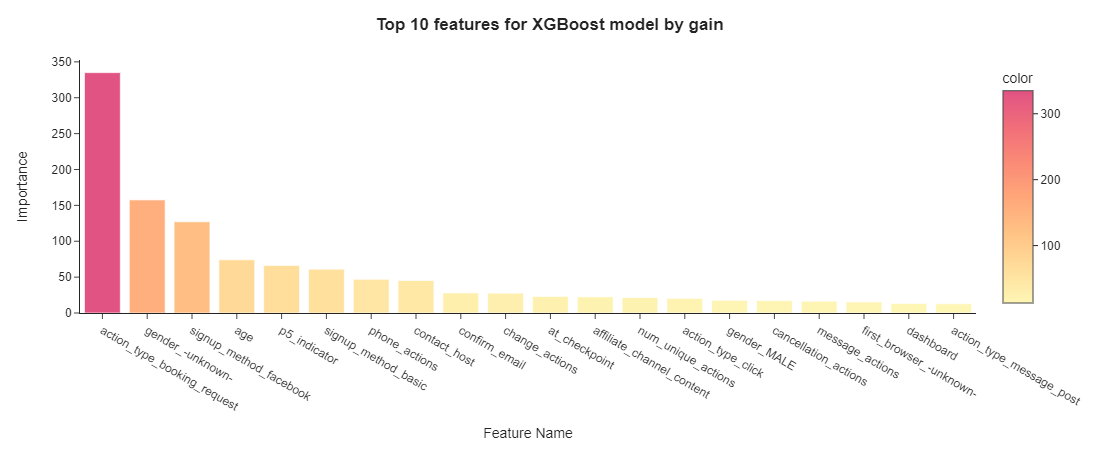